# Can we predict disasters from tweets using NLP?
This is a Kaggle's "Getting Started" competition. I used [a RNN model from TensorFlow](https://www.tensorflow.org/text/tutorials/text_classification_rnn) as the NLP model to solve this problem.

## Section 1: Setup

In [1]:
# packages
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

is_clean = 1
use_glove = 1
if use_glove:
    is_embed_trained = True

In [2]:
# data cleaning
import string, re, os
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

# Stop words a
stopwords_english = stopwords.words('english')

# Stemming (Not good when using pretrained embeddings)
# from nltk.stem import PorterStemmer
# stemmer = PorterStemmer()

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(s, contractions = contractions):
    contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

def process_tweet(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub('\n', '', tweet)
    # remove numbers
    # tweet = re.sub('\w*\d\w*', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet = expand_contractions(tweet)
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = ''
    for word in tweet_tokens:
        # if word not in string.punctuation:
        if (word not in stopwords_english and # remove stopwords
            word not in string.punctuation): # remove punctuation
            # stem_word = stemmer.stem(word) # stemming word
            tweets_clean += ' ' + word
    return tweets_clean

In [3]:
# extract the data
train = pd.read_csv('train.csv')
print('number of tweets: ',train.shape[0])
print('number of disasters: ',np.sum(train["target"]==1))
print('number of non-disasters: ',np.sum(train["target"]==0))
train.head()

number of tweets:  7613
number of disasters:  3271
number of non-disasters:  4342


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test = pd.read_csv('test.csv')
print('number of tweets in test data: ',test.shape[0])
# test.head()

number of tweets in test data:  3263


In [5]:
# split the data into training and validation sets
train_data = train['text'].tolist()
train_label = train['target'].tolist()
test_data = test['text'].tolist()
test_id = test['id'].tolist()
if is_clean:
    print(train_data[:10])
    cleaned = []
    for tweet in train_data:
        cleaned.append(process_tweet(tweet))
    train_data = cleaned.copy()
    print(train_data[:10])
    cleaned = []
    for tweet in test_data:
         cleaned.append(process_tweet(tweet))
    test_data = cleaned.copy() 

import random
np.random.seed(10)
rint = np.random.choice(range(len(train_data)), size=400, replace=False)
         
validation_data = [train_data[i] for i in rint]
validation_label = [train_label[i] for i in rint]
train_data = [train_data[i] for i in range(train.shape[0]) if i not in rint]
train_label = [train_label[i] for i in range(train.shape[0]) if i not in rint]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', 'Forest fire near La Ronge Sask. Canada', "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected", '13,000 people receive #wildfires evacuation orders in California ', 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ', '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires', '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas', "I'm on top of the hill and I can see a fire in the woods...", "There's an emergency evacuation happening now in the building across the street", "I'm afraid that the tornado is coming to our area..."]
[' deeds reason earthquake may allah forgive us', ' forest fire near la ronge sask canada', ' residents asked shelter place notified officers evacuation shelter place orde

In [6]:
# format the data
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_data, validation_label))

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-07-28 22:56:31.888869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/spack/opt/spack/linux-centos7-broadwell/gcc-9.2.0/cudnn-8.2.4.15-11.4-tfeuowyx2bt44r5jk43f6ojqivzlivpd/lib64:/hpc/spack/opt/spack/linux-centos7-broadwell/gcc-9.2.0/cuda-11.4.2-nxqfgxjhusk4pttcrprmdmzfavbbeqdz/lib64:/hpc/spack/opt/spack/linux-centos7-x86_64/gcc-7.3.0/gcc-9.2.0-6zgrndxveon2m5mjhltrqccdcewrdktx/lib64:/hpc/spack/opt/spack/linux-centos7-x86_64/gcc-7.3.0/gcc-9.2.0-6zgrndxveon2m5mjhltrqccdcewrdktx/lib
2022-07-28 22:56:31.888941: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


## Section 2: Model

In [7]:
# encoder
vocab_size = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

# load the whole embedding into memory
if use_glove:
    embeddings_index = dict()
    f = open('./glove.6B.200d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))

    vocab = np.array(encoder.get_vocabulary())
    embed_len = 200
    embedding_matrix = np.zeros((vocab_size, embed_len))
    #for word, i in t.word_index.items():
    for i, word in enumerate(vocab):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        
# top vocabs
# vocab = np.array(encoder.get_vocabulary())
# vocab[:30]

Loaded 400000 word vectors.


In [8]:
# example encoder output
for example, label in train_dataset.take(1):
  print('text: ', example[0].numpy())
  print('label: ', label[0].numpy())
    
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)

text:  b' reading right left'
label:  0
[[  1  99 386   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  1 672 385 270 488   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  1   1   1   1   1 130   1   1 386   1 285   0   0   0   0   0   0   0
    0   0   0]]


In [9]:
# original and round-trip with the encoder
# for n in range(3):
#   print("Original: ", example[n].numpy())
#   print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
#   print()

In [10]:
# use pretrained embeddings?
if use_glove:
    embed_layer = tf.keras.layers.Embedding(vocab_size, embed_len, weights=[embedding_matrix], trainable=is_embed_trained)
else:
    embed_layer = tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)

# model
model = tf.keras.Sequential([
    encoder,
    embed_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=validation_dataset,
                    validation_steps=1)

Epoch 1/10
113/113 [==============================] - 14s 62ms/step - loss: 0.6682 - accuracy: 0.5759 - val_loss: 0.6064 - val_accuracy: 0.6250
Epoch 2/10
113/113 [==============================] - 5s 46ms/step - loss: 0.5269 - accuracy: 0.7322 - val_loss: 0.4928 - val_accuracy: 0.7812
Epoch 3/10
113/113 [==============================] - 5s 45ms/step - loss: 0.4768 - accuracy: 0.7749 - val_loss: 0.4578 - val_accuracy: 0.7812
Epoch 4/10
113/113 [==============================] - 5s 46ms/step - loss: 0.4567 - accuracy: 0.7883 - val_loss: 0.4334 - val_accuracy: 0.7969
Epoch 5/10
113/113 [==============================] - 5s 46ms/step - loss: 0.4460 - accuracy: 0.7898 - val_loss: 0.4203 - val_accuracy: 0.7969
Epoch 6/10
113/113 [==============================] - 5s 47ms/step - loss: 0.4343 - accuracy: 0.8031 - val_loss: 0.4215 - val_accuracy: 0.7812
Epoch 7/10
113/113 [==============================] - 5s 46ms/step - loss: 0.4271 - accuracy: 0.8045 - val_loss: 0.4045 - val_accuracy: 0.781

13/13 [==============================] - 2s 8ms/step
number of tweets:  400
number of correctly classified tweets:  312
accuracy:  0.78


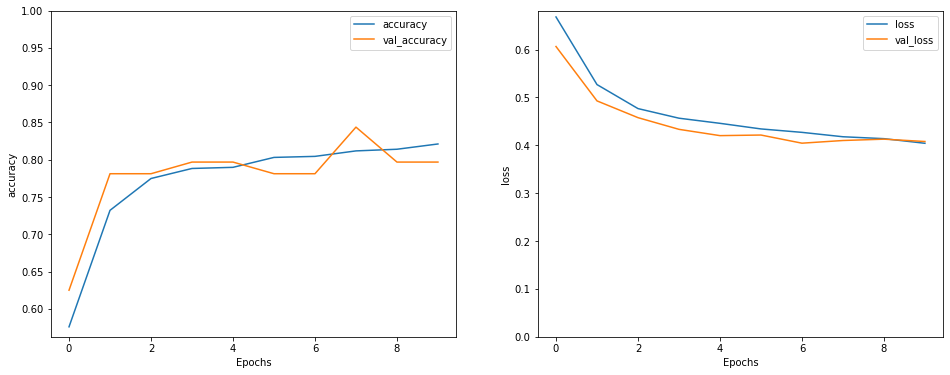

In [11]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

y = model.predict(np.array(validation_data))
y = np.transpose(y)[0]
y = np.multiply(y>0, 1)
target = validation_label
print('number of tweets: ',y.shape[0])
print('number of correctly classified tweets: ',sum((y-target)==0))
print('accuracy: ',sum((y-target)==0)/y.shape[0])

In [12]:
predictions = model.predict(np.array(test_data))
predictions = np.transpose(predictions)[0]
predictions = (predictions>0)
predictions = np.multiply(predictions, 1)
df = pd.DataFrame(data={'id':test_id,'target': np.transpose(predictions).tolist()})
df.head()
df.to_csv('submission.csv',index=False)